# This notebook uses pytorch lightning & optuna & an ANP

This notebook trains an Attentional Neural Network on timeseries data from smartmeters.

It uses pytorch lighting for the training loop. And Optuna for the hyperparameter optimisation.

It also pushes results to the tensorboard hyperparameter dashboard for examination.

- https://github.com/optuna/optuna/blob/master/examples/pytorch_lightning_simple.py

In [2]:
import sys, re, os, itertools, functools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import optuna
import pytorch_lightning as pl
from optuna.integration import PyTorchLightningPruningCallback


import math
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("smartmeters.ipynb")

In [4]:
import torch
from torch import nn
import torch.nn.functional as F

In [5]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
from src.plot import plot_from_loader
from src.models.lightning_anp import LatentModelPL
from src.dict_logger import DictLogger

In [6]:
# Params
device='cuda'
use_logy=False

# Load kaggle smart meter data

In [7]:
df_train, df_test = get_smartmeter_df()

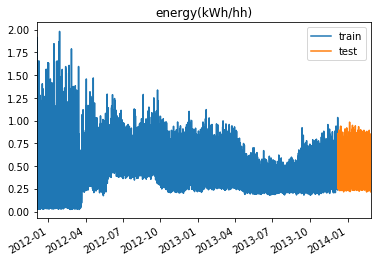

In [8]:
# Show split
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Hyperparam search

In [9]:
PERCENT_TEST_EXAMPLES = 0.3
EPOCHS = 2
DIR = Path(os.getcwd())
MODEL_DIR = DIR/ 'optuna_result'/ 'anp3'
name = 'anp2' # study name
MODEL_DIR.mkdir(parents=True, exist_ok=True)
print(f"now run `tensorboard --logdir {MODEL_DIR}")

now run `tensorboard --logdir /media/wassname/Storage5/projects2/3ST/attentive-neural-processes/optuna_result/anp3


In [10]:
def main(trial, train=True):    
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        os.path.join(MODEL_DIR, name, 'version_{}'.format(trial.number), "chk"), monitor='val_loss', mode="min")

    # The default logger in PyTorch Lightning writes to event files to be consumed by
    # TensorBoard. We create a simple logger instead that holds the log in memory so that the
    # final accuracy can be obtained after optimization. When using the default logger, the
    # final accuracy could be stored in an attribute of the `Trainer` instead.
    logger = DictLogger(MODEL_DIR, name="anp", version=trial.number)

    trainer = pl.Trainer(
        logger=logger,
        val_percent_check=PERCENT_TEST_EXAMPLES,
        gradient_clip_val=trial.params["grad_clip"],
        checkpoint_callback=checkpoint_callback,
        max_epochs=trial.params['max_nb_epochs'],
        gpus=-1 if torch.cuda.is_available() else None,
        early_stop_callback=PyTorchLightningPruningCallback(trial, monitor='val_loss')
    )
    model = LatentModelPL(trial.params)
    if train:
        trainer.fit(model)
    
    return model, trainer


def add_sugg(trial):
    
    trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)

    trial.suggest_categorical("hidden_dim", [8*2**i for i in range(6)])
    trial.suggest_categorical("latent_dim", [8*2**i for i in range(6)])
    
    trial.suggest_int("attention_layers", 1, 4)
    trial.suggest_categorical("n_latent_encoder_layers", [1, 2, 4, 8])
    trial.suggest_categorical("n_det_encoder_layers", [1, 2, 4, 8])
    trial.suggest_categorical("n_decoder_layers", [1, 2, 4, 8])

#     trial.suggest_uniform("dropout", 0, 0.75)
#     trial.suggest_uniform("attention_dropout", 0, 0.75)
    trial.suggest_categorical("dropout", [0, 0.2, 0.5])
    trial.suggest_categorical("attention_dropout", [0, 0.2, 0.5])

    trial.suggest_categorical(
        "latent_enc_self_attn_type", ['multihead', 'ptmultihead']
    )
#     trial.suggest_categorical(
#         "latent_enc_self_attn_type", ['uniform', 'dot', 'multihead', 'ptmultihead']
#     )
#     trial.suggest_categorical("det_enc_self_attn_type", ['uniform', 'dot', 'multihead', 'ptmultihead'])
#     trial.suggest_categorical("det_enc_cross_attn_type", ['uniform', 'dot', 'multihead', 'ptmultihead'])
    trial.suggest_categorical("det_enc_self_attn_type",  ['multihead', 'ptmultihead'])
    trial.suggest_categorical("det_enc_cross_attn_type", ['multihead', 'ptmultihead'])

    trial.suggest_categorical("batchnorm", [False, True])
    trial.suggest_categorical("use_self_attn", [False, True])
    trial.suggest_categorical("use_lvar", [False, True])
    trial.suggest_categorical("use_deterministic_path", [False, True])

    # training specific (for this model)
    trial.suggest_uniform("min_std", 0.005, 0.005)
    trial.suggest_int("grad_clip", 40, 40)
    trial.suggest_int("num_context", 24 * 6, 24 * 6)
    trial.suggest_int("num_extra_target", 24*2, 24*2)
    trial.suggest_int("max_nb_epochs", 10, 10)
    trial.suggest_int("num_workers", 3, 3)
    trial.suggest_int("batch_size", 16, 16)
    trial.suggest_int("num_heads", 8, 8)

    trial.suggest_int("x_dim", 17, 17)
    trial.suggest_int("y_dim", 1, 1)
    trial.suggest_int("vis_i", 670, 670)
    return trial

def objective(trial):
    # see https://github.com/optuna/optuna/blob/cf6f02d/examples/pytorch_lightning_simple.py
    
    trial = add_sugg(trial)
    
    print('trial', trial.number, 'params', trial.params)
    
    
    # PyTorch Lightning will try to restore model parameters from previous trials if checkpoint
    # filenames match. Therefore, the filenames for each trial must be made unique.
    model, trainer = main(trial)
    
    # also report to tensorboard & print
    print('logger.metrics', model.logger.metrics[-1:])
    model.logger.experiment.add_hparams(trial.params, model.logger.metrics[-1])
    
    return model.logger.metrics[-1]['val_loss']


In [11]:
import argparse 

parser = argparse.ArgumentParser(description='PyTorch Lightning example.')
parser.add_argument('--pruning', '-p', action='store_true',
                    help='Activate the pruning feature. `MedianPruner` stops unpromising '
                         'trials at the early stages of training.')
args = parser.parse_args(['-p'])

pruner = optuna.pruners.MedianPruner() if args.pruning else optuna.pruners.NopPruner()

study = optuna.create_study(direction='minimize', pruner=pruner, storage=f'sqlite:///optuna_result/{name}.db', study_name=name, load_if_exists=True)


[I 2020-02-02 07:50:58,105] Using an existing study with name 'anp2' instead of creating a new one.


In [12]:
study.optimize(objective, n_trials=200, timeout=pd.Timedelta('2d').total_seconds())

KeyboardInterrupt: 

In [ ]:

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

# shutil.rmtree(MODEL_DIR)

# View

TODO

In [ ]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
df.sort_values('value')

In [ ]:
df.sort_values('value').head(17).T

# Test

TODO test best

In [ ]:
trial = study.best_trial

In [18]:
# try:
#     trial = study.best_trial
# except ValueError as e:
#     logging.warning(f"Could not load best trial as: '{e}'")
#     trial = study.get_trials(1)[0]
# trial.params

In [14]:
trial = optuna.trial.FixedTrial({'attention_dropout': 0.2,
 'attention_layers': 2,
 'batch_size': 16,
 'batchnorm': False,
 'det_enc_cross_attn_type': 'multihead',
 'det_enc_self_attn_type': 'ptmultihead',
 'dropout': 0,
 'grad_clip': 40,
 'hidden_dim': 64,
 'latent_dim': 64,
 'latent_enc_self_attn_type': 'multihead',
 'learning_rate': 0.0019,
 'max_nb_epochs': 10,
 'min_std': 0.005,
 'n_decoder_layers': 2,
 'n_det_encoder_layers': 8,
 'n_latent_encoder_layers': 1,
 'num_context': 24*6,
 'num_extra_target': 24*2,
 'num_heads': 8,
 'num_workers': 3,
 'use_deterministic_path': False,
 'use_lvar': True,
 'use_self_attn': True,
 'vis_i': '670',
 'x_dim': 17,
 'y_dim': 1,
                                 
                                })
trial = add_sugg(trial)
trial.number = 1002

/media/wassname/Storage5/projects2/3ST/pytorch-lightning/pytorch_lightning/callbacks/pt_callbacks.py:239: UserWarning:

Checkpoint directory /media/wassname/Storage5/projects2/3ST/attentive-neural-processes/optuna_result/anp3/anp2/version_1002/chk exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                   Name           Type Params
0                                 model    LatentModel  374 K
1                 model._latent_encoder  LatentEncoder  148 K
2    model._latent_encoder._input_layer         Linear    1 K
3        model._latent_encoder._encoder     ModuleList    4 K
4      model._latent_encoder._encoder.0  NPBlockRelu2d    4 K
..                                  ...            ...    ...
179    model._decoder._decoder.1.linear         Linear   16 K
180       model._decoder._decoder.1.act           ReLU    0

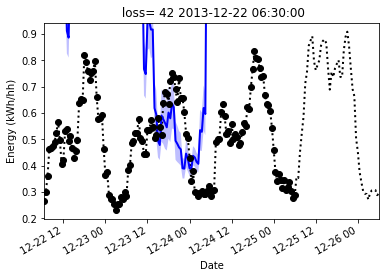

step 4403, {'val_loss': '115.8714599609375', 'val/kl': '0.040124934166669846', 'val/mse': '8.647311210632324', 'val/std': '0.18496380746364594'}


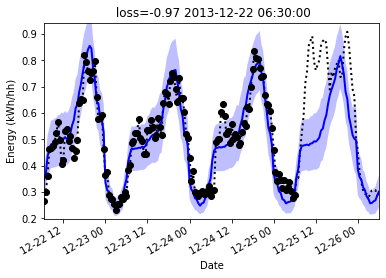

step 6597, {'val_loss': '-1.337040662765503', 'val/kl': '0.0005833097966387868', 'val/mse': '0.005153971258550882', 'val/std': '0.07907649874687195'}


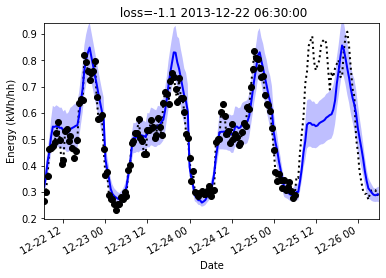

step 8792, {'val_loss': '-1.4710036516189575', 'val/kl': '0.0004436351009644568', 'val/mse': '0.0037921438924968243', 'val/std': '0.061363283544778824'}


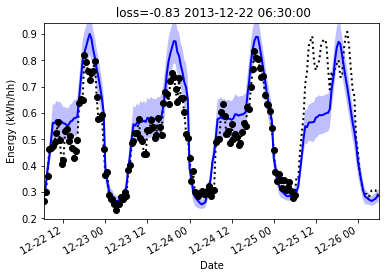

step 10987, {'val_loss': '-1.4116109609603882', 'val/kl': '0.000349979818565771', 'val/mse': '0.0038589625619351864', 'val/std': '0.05318635329604149'}


INFO:root:Epoch 00004: early stopping


1

In [15]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    os.path.join(MODEL_DIR, name, 'version_{}'.format(trial.number), "chk"), monitor='val_loss', mode="min")

logger = DictLogger(MODEL_DIR, name="anp", version=trial.number)

trainer = pl.Trainer(
    gradient_clip_val=trial.params["grad_clip"],
    checkpoint_callback=checkpoint_callback,
    max_epochs=trial.params['max_nb_epochs'],
    gpus=-1 if torch.cuda.is_available() else None,
    early_stop_callback=True
)
model = LatentModelPL(trial.params)

trainer.fit(model)

tensor(-1.0789, device='cuda:0')

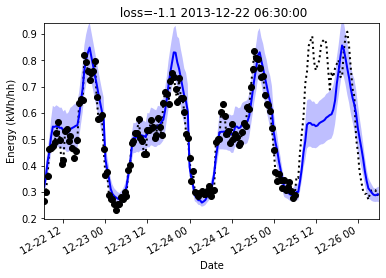

In [19]:
# plot
loader = model.val_dataloader()[0]
vis_i=670
plot_from_loader(loader, model, i=vis_i)

INFO:root:
                                   Name           Type Params
0                                 model    LatentModel  374 K
1                 model._latent_encoder  LatentEncoder  148 K
2    model._latent_encoder._input_layer         Linear    1 K
3        model._latent_encoder._encoder     ModuleList    4 K
4      model._latent_encoder._encoder.0  NPBlockRelu2d    4 K
..                                  ...            ...    ...
179    model._decoder._decoder.1.linear         Linear   16 K
180       model._decoder._decoder.1.act           ReLU    0  
181   model._decoder._decoder.1.dropout      Dropout2d    0  
182                model._decoder._mean         Linear  129  
183                 model._decoder._std         Linear  129  

[184 rows x 3 columns]
INFO:root:model and trainer restored from checkpoint: /media/wassname/Storage5/projects2/3ST/attentive-neural-processes/optuna_result/anp3/anp2/version_1002/chk/_ckpt_epoch_2.ckpt


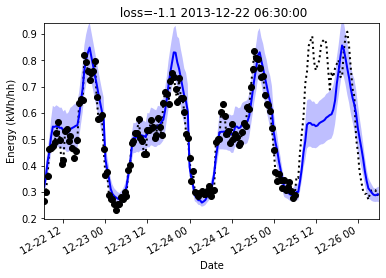

step 8792, {'val_loss': '-1.4710036516189575', 'val/kl': '0.0004436351009644568', 'val/mse': '0.0037921438924968243', 'val/std': '0.061363283544778824'}



In [17]:
# test
trainer.test(model)